# Poisson Regression

Gaussian process models can be incredibly flexbile for modelling non-Gaussian data. One such example is in the case of count data $\mathbf{y}$, which can be modelled with a __Poisson model__ with a latent Gaussian process.
$$
\mathbf{y} \ | \ \mathbf{f} \sim \prod_{i=1}^{n} \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},
$$
where $\lambda_i=\exp(f_i)$ and $f_i$ is the latent Gaussian process.


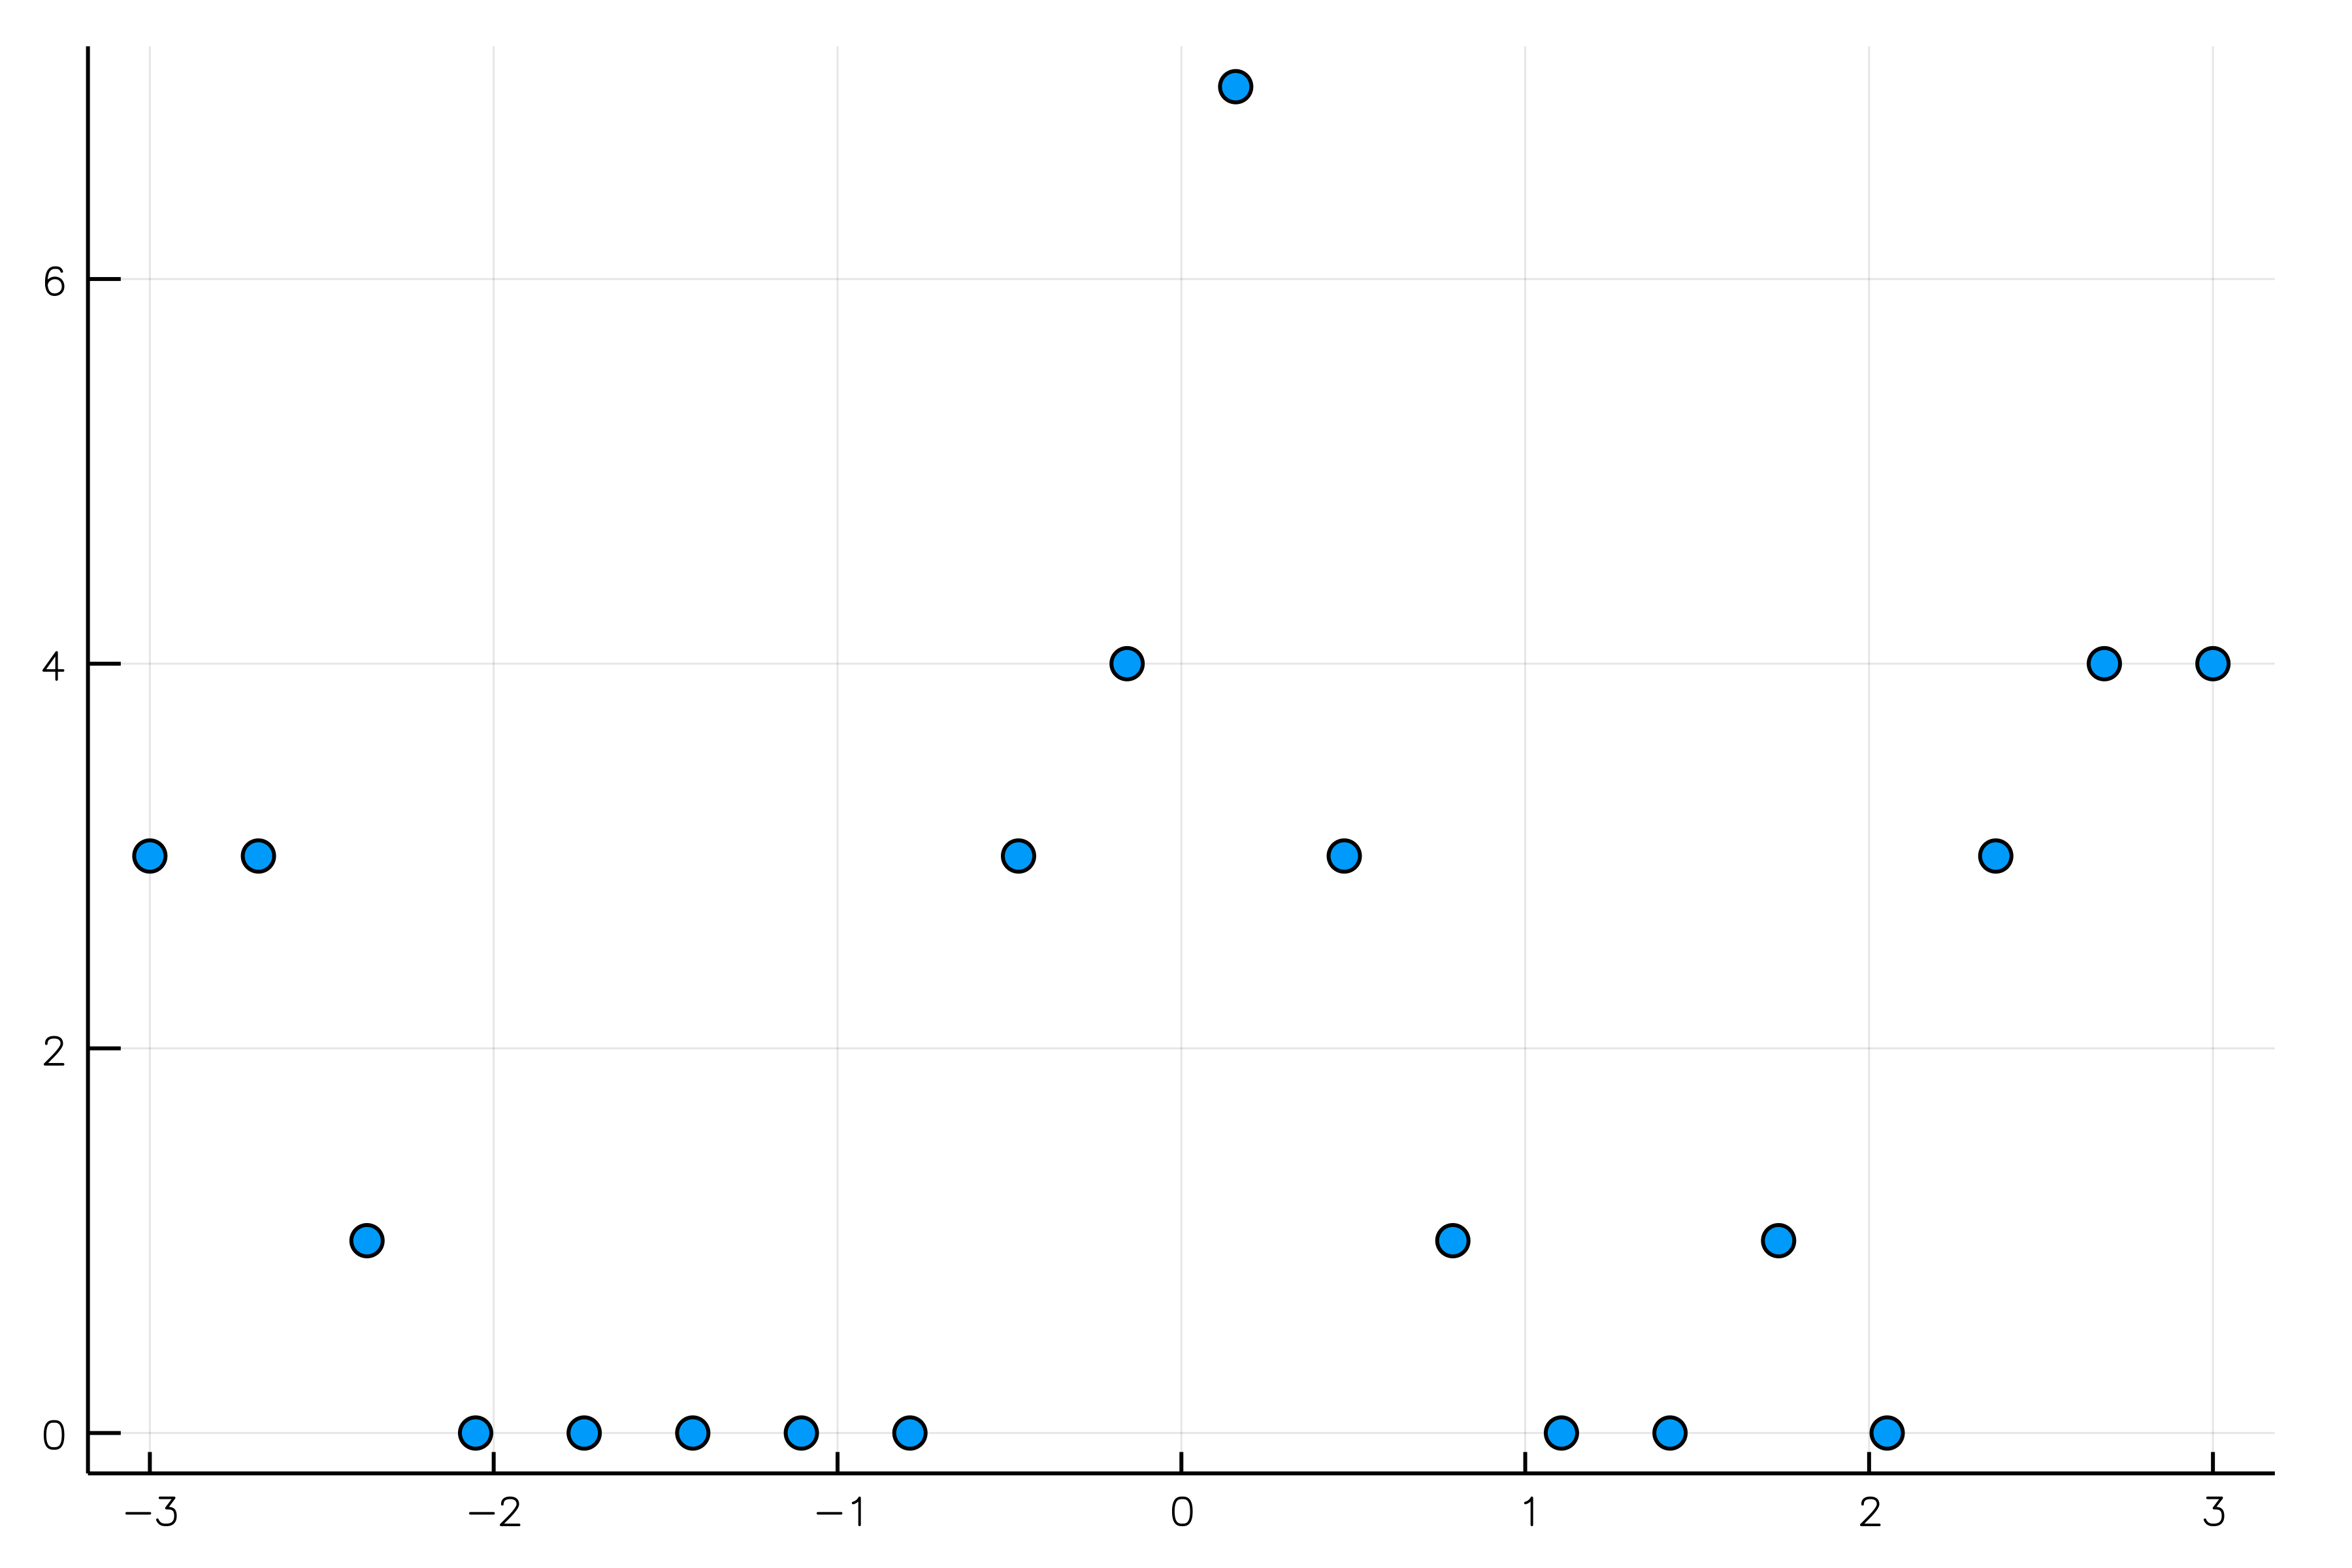

In [1]:
#Load the package
using GaussianProcesses

#Simulate the data
srand(203617)
n = 20
X = collect(linspace(-3,3,n));
f = 2*cos.(2*X);
Y = [rand(Distributions.Poisson(exp.(f[i]))) for i in 1:n];

#Plot the data using the Plots.jl package with the GR backend
using Plots
gr()
scatter(X,Y,leg=false, fmt=:png)

In [2]:
#GP set-up
k = Matern(3/2,0.0,0.0)   # Matern 3/2 kernel
l = PoisLik()             # Poisson likelihood
gp = GP(X, vec(Y), MeanZero(), k, l)

GP Monte Carlo object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.Mat32Iso, Params: [0.0, 0.0]
  Likelihood:
    Type: GaussianProcesses.PoisLik, Params: Any[]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [3, 3, 1, 0, 0, 0, 0, 0, 3, 4, 7, 3, 1, 0, 0, 1, 0, 3, 4, 4]
  Log-posterior = -65.397

In [3]:
set_priors!(gp.k,[Distributions.Normal(-2.0,4.0),Distributions.Normal(-2.0,4.0)])
@time samples = mcmc(gp; nIter=10000);

Number of iterations = 10000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 9.994100 
Number of function calls: 99942
Acceptance rate: 0.809100 
  9.028309 seconds (37.70 M allocations: 2.456 GiB, 4.70% gc time)


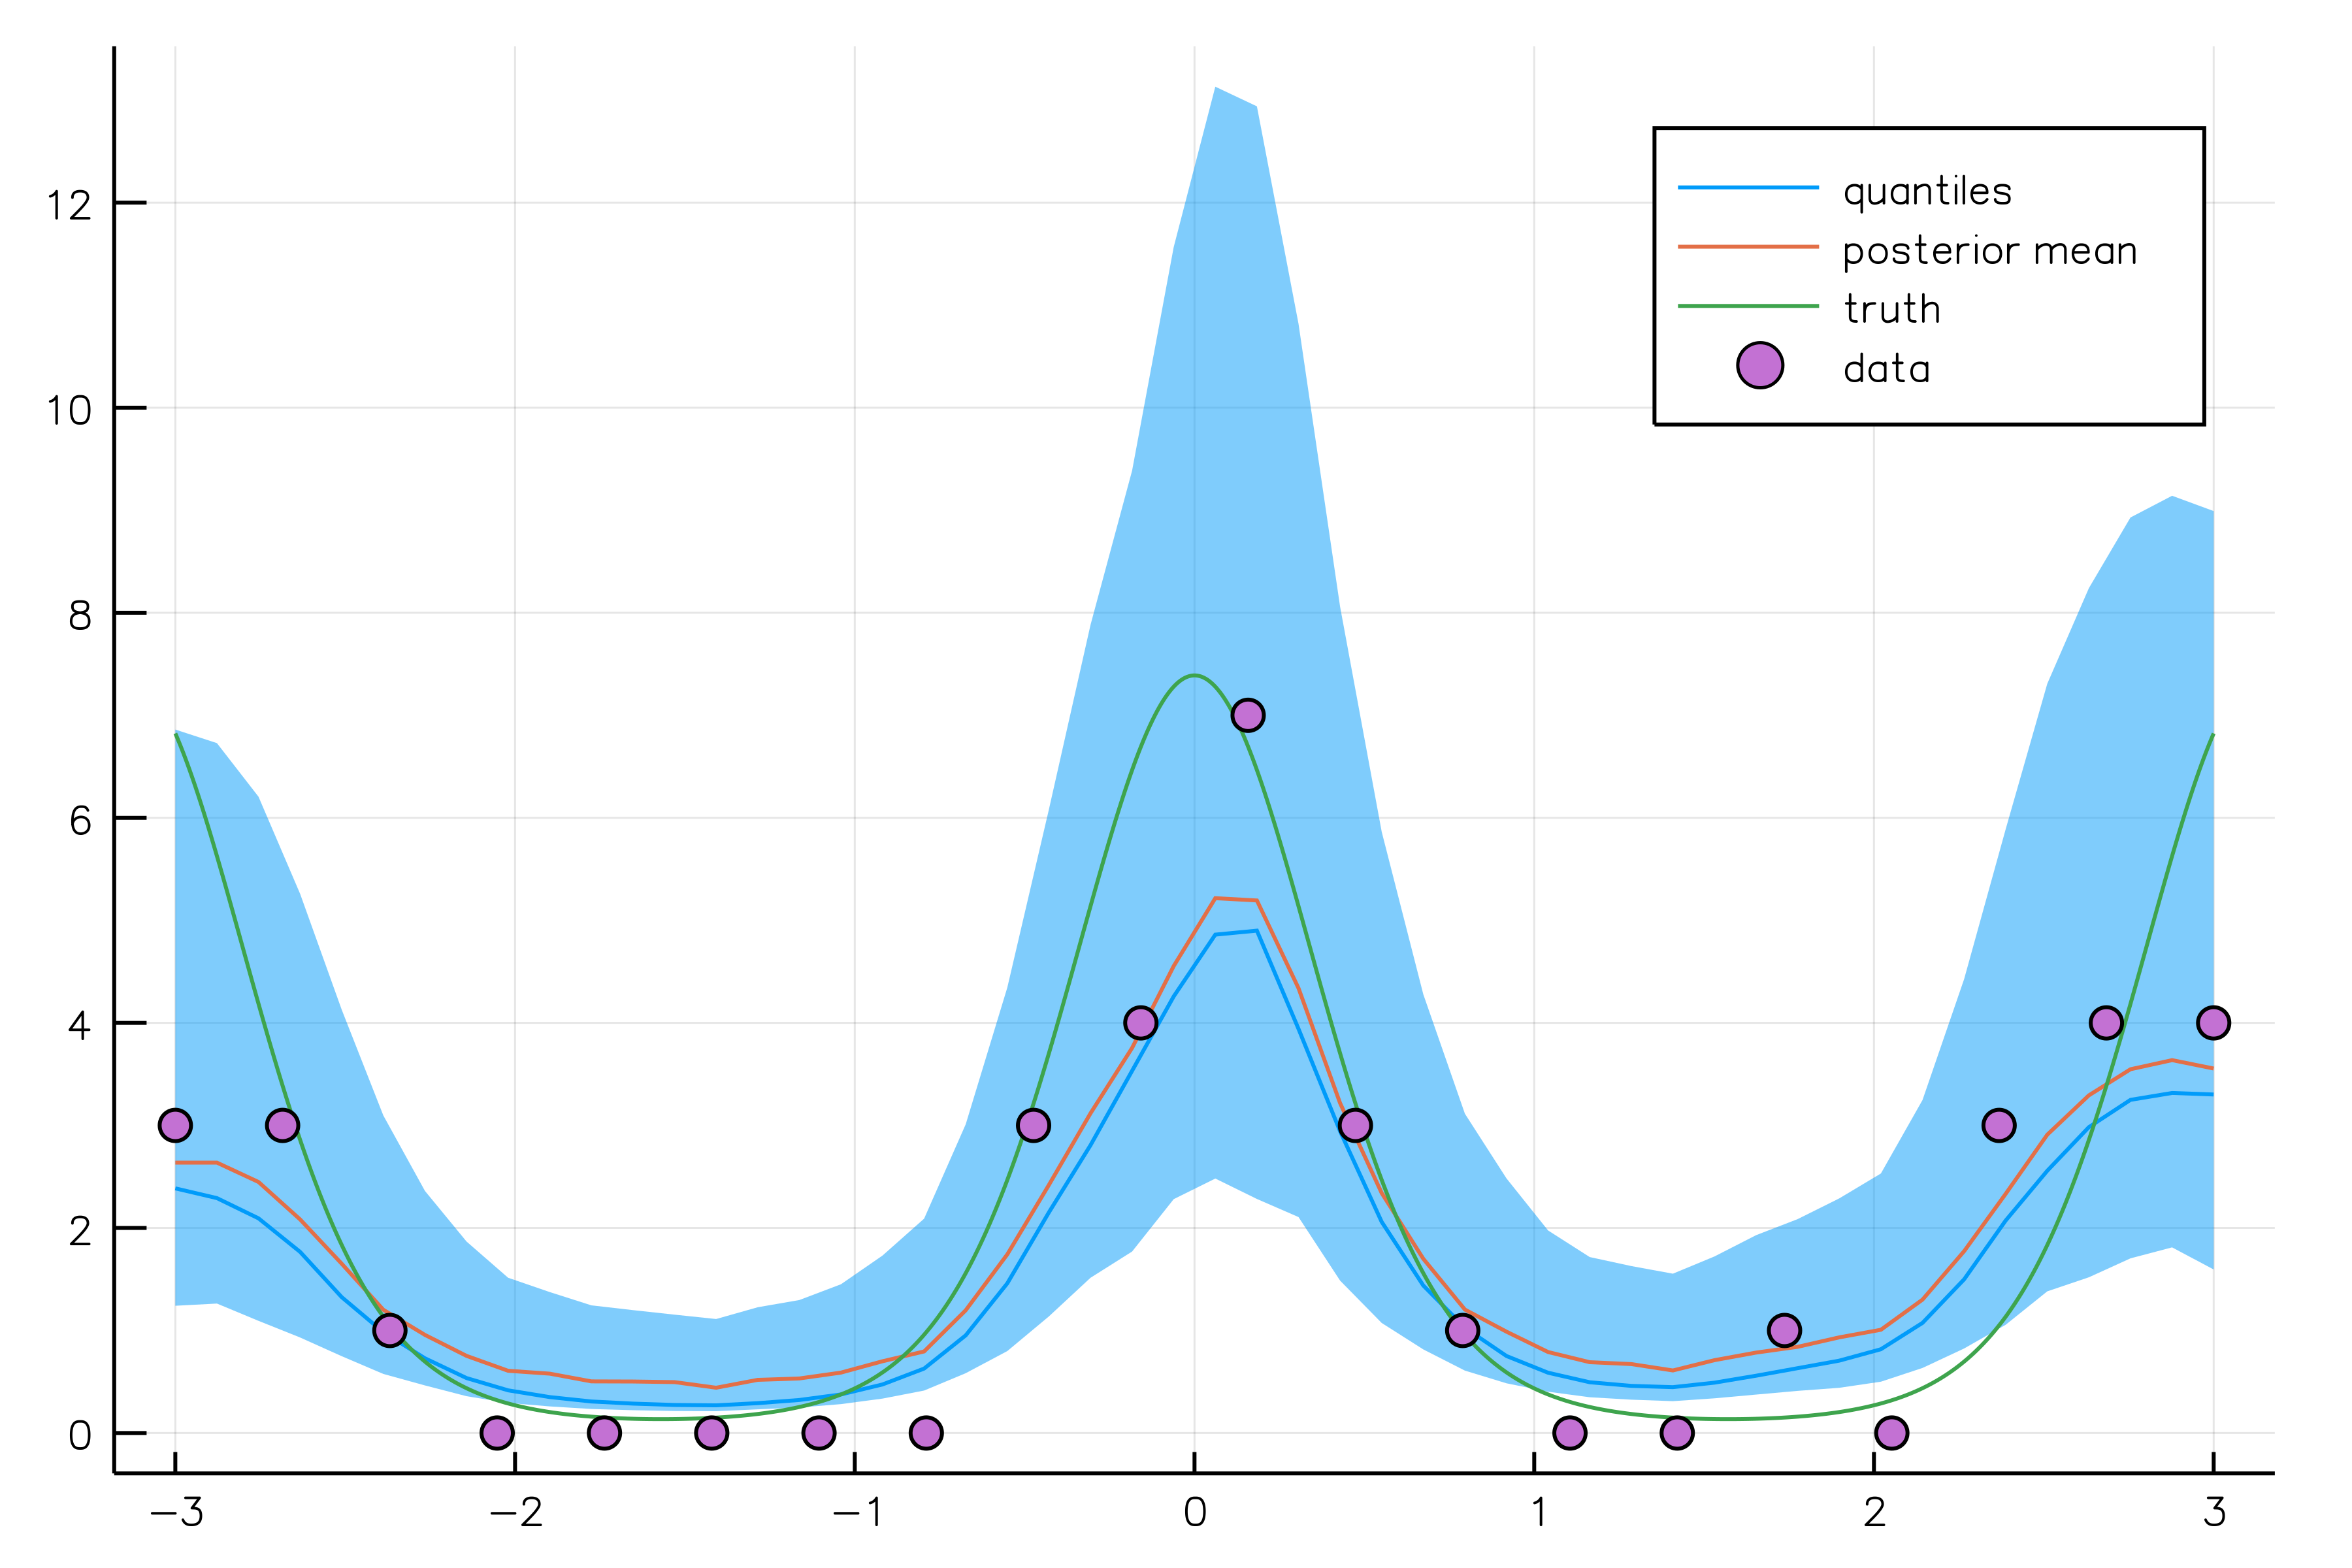

In [4]:
#Sample predicted values
xtest = linspace(minimum(gp.X),maximum(gp.X),50);
ymean = [];
fsamples = Array{Float64}(size(samples,2), length(xtest));
for i in 1:size(samples,2)
    set_params!(gp,samples[:,i])
    update_target!(gp)
    push!(ymean, predict_y(gp,xtest)[1])
    fsamples[i,:] = rand(gp, xtest)
end

#Predictive plots

q10 = [quantile(fsamples[:,i], 0.1) for i in 1:length(xtest)]
q50 = [quantile(fsamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(fsamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest,exp.(q50),ribbon=(exp.(q10), exp.(q90)),leg=true, fmt=:png, label="quantiles")
plot!(xtest,mean(ymean), label="posterior mean")
xx = linspace(-3,3,1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")